In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns

import random

import warnings
warnings.filterwarnings("ignore")

From now on _edf will denote exploratory dataframes, with raw scale data and no columns dropped nor missing values filled. Missing values do not need to be filled in order for data to be visualized. New features will also be included and added as necessary

_ppdf will denote preprocessed dataframes that are ready to be modeled. All missing values will be filled, all features normalized as best as possible, and categorical data binarized.

DataFrames without these suffixes will either be intermediary dataframes as features are aggregated onto it, or it will be the raw state data from the data source. 

In [189]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
additional_charges            10000 non-null float64
dropoff_census_tract          7187 non-null object
dropoff_centroid_latitude     9334 non-null object
dropoff_centroid_location     9334 non-null object
dropoff_centroid_longitude    9334 non-null object
dropoff_community_area        9322 non-null object
fare                          10000 non-null float64
pickup_census_tract           7207 non-null object
pickup_centroid_latitude      9392 non-null object
pickup_centroid_location      9392 non-null object
pickup_centroid_longitude     9392 non-null object
pickup_community_area         9383 non-null object
shared_trip_authorized        10000 non-null bool
tip                           10000 non-null float64
trip_end_timestamp            10000 non-null object
trip_id                       10000 non-null object
trip_miles                    10000 non-null float64
trip_seconds    

In [9]:
trips.head()

,additional_charges,dropoff_census_tract,dropoff_centroid_latitude,dropoff_centroid_location,dropoff_centroid_longitude,dropoff_community_area,fare,pickup_census_tract,pickup_centroid_latitude,pickup_centroid_location,...,pickup_community_area,shared_trip_authorized,tip,trip_end_timestamp,trip_id,trip_miles,trip_seconds,trip_start_timestamp,trip_total,trips_pooled
0,2.55,1.703132e+10,41.884987,"{'type': 'Point', 'coordinates': [-87.62099291...",-87.620993,32.0,12.5,1.703108e+10,41.890922,"{'type': 'Point', 'coordinates': [-87.61886835...",...,8.0,False,0,2019-05-21T08:15:00.000,132888eddb0daa305a25fff76ef8f2b486a3b9e0,0.893805,498.0,2019-05-21T08:15:00.000,15.05,1
1,2.55,1.703101e+10,42.021224,"{'type': 'Point', 'coordinates': [-87.66982477...",-87.669825,1.0,5.0,1.703101e+10,42.000320,"{'type': 'Point', 'coordinates': [-87.66312679...",...,1.0,False,0,2019-05-17T20:45:00.000,13288927bab65e06e0bd8c19e2509556da405379,2.245223,560.0,2019-05-17T20:45:00.000,7.55,1
2,7.55,1.703108e+10,41.890922,"{'type': 'Point', 'coordinates': [-87.61886835...",-87.618868,8.0,22.5,1.703198e+10,41.785999,"{'type': 'Point', 'coordinates': [-87.75093428...",...,56.0,False,5,2019-06-03T14:15:00.000,13288954182feebad4b59d3b7a961f3de390004c,12.805787,2131.0,2019-06-03T13:30:00.000,35.05,1
3,0.00,NaN,NaN,NaN,NaN,NaN,35.0,1.703198e+10,41.979071,"{'type': 'Point', 'coordinates': [-87.90303966...",...,76.0,True,0,2019-05-15T12:45:00.000,132889d3145a4d708c8c05537b78bbe0fe6da181,24.466280,1717.0,2019-05-15T12:15:00.000,35.00,1
4,2.55,1.703183e+10,41.879067,"{'type': 'Point', 'coordinates': [-87.65700502...",-87.657005,28.0,7.5,1.703183e+10,41.916005,"{'type': 'Point', 'coordinates': [-87.67509511...",...,22.0,False,0,2019-06-29T17:15:00.000,13288af9e8dd1eff9f5be9e0dc665c2c037bde90,3.691282,783.0,2019-06-29T17:00:00.000,10.05,1


In [26]:
from sodapy import Socrata

client = Socrata("data.cityofchicago.org", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("m6dm-c72p", limit=10000)

# Convert to pandas DataFrame
trips = pd.DataFrame.from_records(results)

In [27]:
trips.shape

(10000, 21)

In [28]:
#for col in trips_df.columns:
# print(trips_df[col].nunique)
trips['dropoff_census_tract'].nunique()

557

In [30]:
trips['dropoff_centroid_location'][0]

{'type': 'Point', 'coordinates': [-87.6197106717, 41.8950334495]}

In [31]:
trips.columns

Index(['additional_charges', 'dropoff_census_tract',
       'dropoff_centroid_latitude', 'dropoff_centroid_location',
       'dropoff_centroid_longitude', 'dropoff_community_area', 'fare',
       'pickup_census_tract', 'pickup_centroid_latitude',
       'pickup_centroid_location', 'pickup_centroid_longitude',
       'pickup_community_area', 'shared_trip_authorized', 'tip',
       'trip_end_timestamp', 'trip_id', 'trip_miles', 'trip_seconds',
       'trip_start_timestamp', 'trip_total', 'trips_pooled'],
      dtype='object')

Preprocessed . DFT (DataFrame Transformed) . 

## Cleaning and Filling Empty Data

In [33]:
trips_dft = trips[['additional_charges', 'dropoff_census_tract',
       'dropoff_centroid_latitude',
       'dropoff_centroid_longitude', 'dropoff_community_area', 'fare',
       'pickup_census_tract', 'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_community_area', 'shared_trip_authorized', 'tip',
       'trip_end_timestamp', 'trip_id', 'trip_miles', 'trip_seconds',
       'trip_start_timestamp', 'trip_total', 'trips_pooled']]


In [81]:
dist_cols = ['additional_charges', 'fare', 'tip', 'trip_miles', 'trip_seconds', 'trip_total', 'trips_pooled']

for col in dist_cols:
    trips_dft[col] = trips[col].astype('float64')
    trips[col] = trips[col].astype('float64')

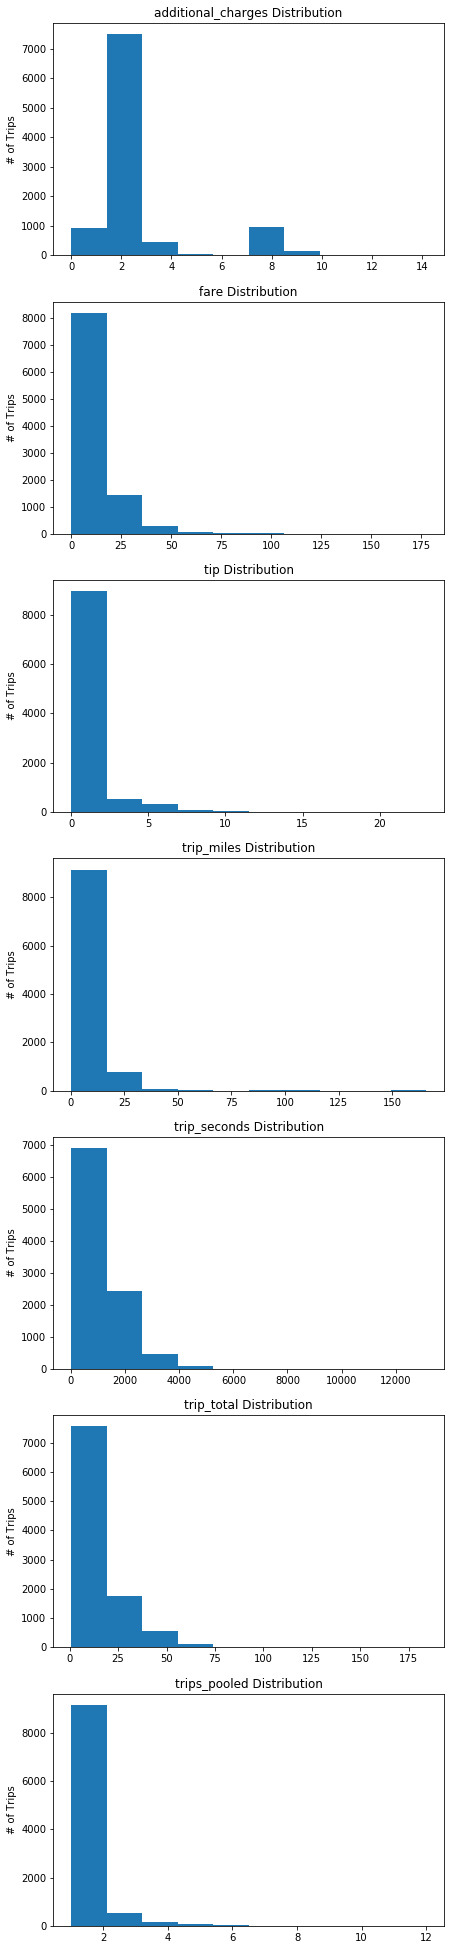

In [79]:
plt.figure(figsize = (7,35))
for i in range(len(dist_cols)):
    plt.subplot(len(dist_cols), 1, i+1) 
    plt.hist(trips_dft[dist_cols[i]])
    plt.title(dist_cols[i] + ' ' + 'Distribution')
    plt.ylabel('# of Trips')
plt.show()
    #trip_plot.title(col+ ' ' + 'Distribution')
    #trip_plot.ylabel('# of Trips')
    #trip_plot.show()

(array([  96.,    0.,    0.,    0.,    0.,  565., 4043., 4363.,  899.,
          34.]),
 array([-4.60517019, -3.62675047, -2.64833076, -1.66991105, -0.69149133,
         0.28692838,  1.26534809,  2.24376781,  3.22218752,  4.20060723,
         5.17902695]),
 <a list of 10 Patch objects>)

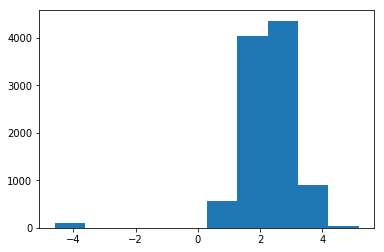

In [57]:
#type(trips_dft['fare'][0])
plt.figure()
plt.hist(np.log(trips_dft['fare'] + 0.01))

In [62]:
trips_dft.dtypes

additional_charges            float64
dropoff_census_tract           object
dropoff_centroid_latitude      object
dropoff_centroid_longitude     object
dropoff_community_area         object
fare                          float64
pickup_census_tract            object
pickup_centroid_latitude       object
pickup_centroid_longitude      object
pickup_community_area          object
shared_trip_authorized           bool
tip                           float64
trip_end_timestamp             object
trip_id                        object
trip_miles                    float64
trip_seconds                  float64
trip_start_timestamp           object
trip_total                    float64
trips_pooled                  float64
dtype: object

In [82]:
trips[dist_cols].skew()

additional_charges    1.721584
fare                  3.301377
tip                   3.998750
trip_miles            3.788543
trip_seconds          2.034467
trip_total            2.967728
trips_pooled          3.930077
dtype: float64

In [83]:
for col in dist_cols:
    trips_dft[col] = np.log(trips[col] + 1)

In [84]:
trips_dft[dist_cols].skew()

additional_charges   -0.689967
fare                  0.009687
tip                   2.118847
trip_miles            0.479105
trip_seconds         -0.194794
trip_total            0.437227
trips_pooled          2.709021
dtype: float64

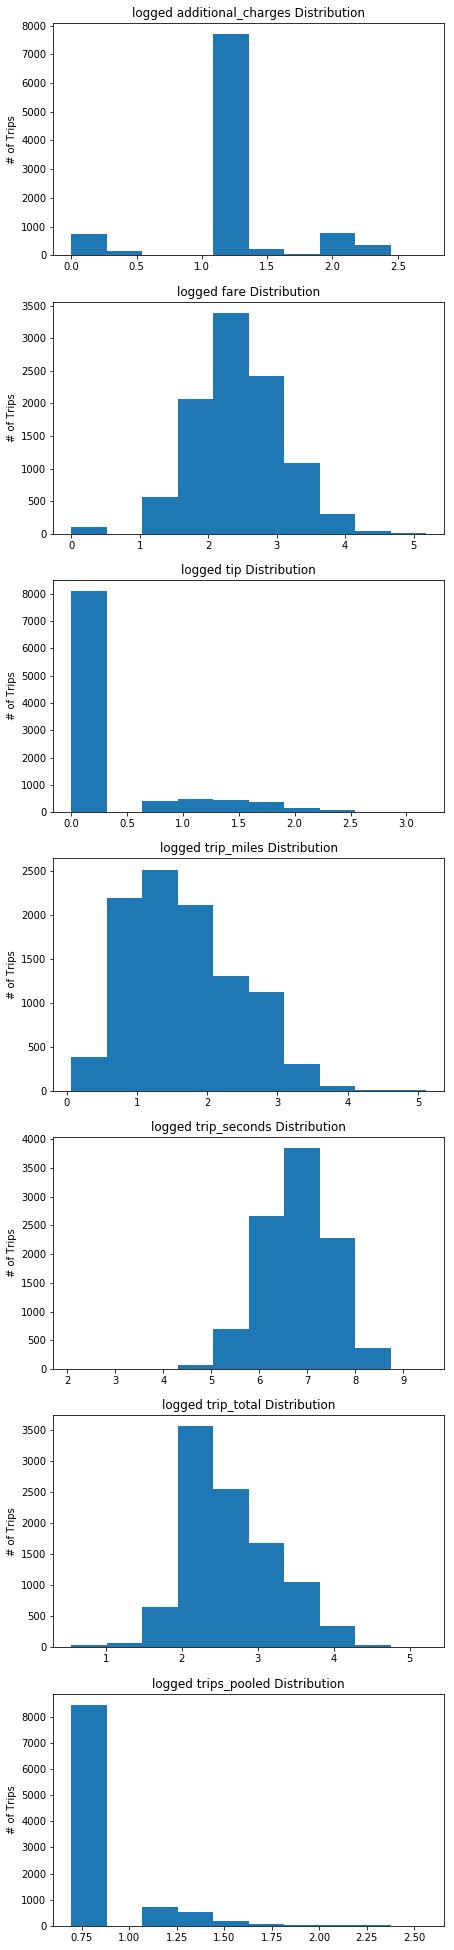

In [85]:
plt.figure(figsize = (7,35))
for i in range(len(dist_cols)):
    plt.subplot(len(dist_cols), 1, i+1) 
    plt.hist(trips_dft[dist_cols[i]])
    plt.title('logged' + ' ' + dist_cols[i] + ' ' + 'Distribution')
    plt.ylabel('# of Trips')
plt.show()

(array([719., 520., 176.,  73.,  27.,  12.,   8.,   5.,   0.,   2.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <a list of 10 Patch objects>)

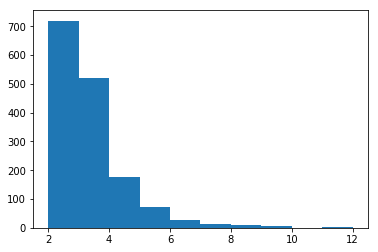

In [102]:
plt.figure()
plt.hist(trips[trips['trips_pooled'] > 1]['trips_pooled'])

In [100]:
trips[trips['tip'] > 0]['tip'].describe()

count    1897.000000
mean        3.337902
std         2.477579
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        23.000000
Name: tip, dtype: float64

Checking the distributions, it's certainly best to keep all of the distributions logged for the sake of predictive convenience for the models. Although it appears that tips and trips_pooled appear heavily right-skewed even after log transforming them, this only because all the non-pooled and non-tipped trips are included in the distribution. Above the zero values, the distributions become more normal when log transformed.

In [104]:
trips_dft['shared_trip_authorized'] = trips_dft['shared_trip_authorized'].replace([True, False], [1,0])

In [107]:
trips_dft['shared_trip_authorized'].mean()

0.2232

In [112]:
trips_dft.dtypes

additional_charges            float64
dropoff_census_tract           object
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dropoff_community_area         object
fare                          float64
pickup_census_tract            object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
pickup_community_area          object
shared_trip_authorized          int64
tip                           float64
trip_end_timestamp             object
trip_id                        object
trip_miles                    float64
trip_seconds                  float64
trip_start_timestamp           object
trip_total                    float64
trips_pooled                  float64
dtype: object

In [111]:
float_cols = ['dropoff_centroid_latitude','dropoff_centroid_longitude','pickup_centroid_latitude','pickup_centroid_longitude']
for col in float_cols:
    trips_dft[col] = trips[col].astype('float64')
    

In [118]:
#pd.Timestamp(trips_dft['trip_end_timestamp'])
for i in trips['trip_end_timestamp']:
    i.split('T')

In [122]:
d, t = trips['trip_end_timestamp'][0].split('T')
print(d)
print(t)
year, month, day = d.split('-')
hour, minute, sec = t.split(':')
print(year)
print(month)
print(day)
print(hour)
print(minute)
print(sec)

2019-06-04
08:00:00.000
2019
06
04
08
00
00.000


In [128]:
ts_year = []
ts_month = []
ts_day = []
ts_hour = []
ts_minute = []
ts_sec = []

for i in range(len(trips['trip_end_timestamp'])):
    
    d, t = trips['trip_end_timestamp'][i].split('T')
    
    year, month, day = d.split('-')
    hour, minute, sec = t.split(':')
    
    ts_year.append(year)
    ts_month.append(month)
    ts_day.append(day)
    ts_hour.append(hour)
    ts_minute.append(minute)
    ts_sec.append(sec)

trips_dft['tsend_year'] = ts_year
trips_dft['tsend_month'] = ts_month
trips_dft['tsend_day'] = ts_day
trips_dft['tsend_hour'] = ts_hour
trips_dft['tsend_minute'] = ts_minute
trips_dft['tsend_sec'] = ts_sec

trips_dft['tsend_year'] = trips_dft['tsend_year'].astype('int64')
trips_dft['tsend_month'] = trips_dft['tsend_month'].astype('int64')
trips_dft['tsend_day'] = trips_dft['tsend_day'].astype('int64')
trips_dft['tsend_hour'] = trips_dft['tsend_hour'].astype('int64')
trips_dft['tsend_minute'] = trips_dft['tsend_minute'].astype('int64')
trips_dft['tsend_sec'] = trips_dft['tsend_sec'].astype('float64')

In [ ]:
timestamp_end_cols = ['tsend_year', 'tsend_month', 'tsend_day', 'tsend_hour', 'tsend_minute', 'tsend_sec']
trips_dft[timestamp_end_cols].head()

In [130]:
ts_year = []
ts_month = []
ts_day = []
ts_hour = []
ts_minute = []
ts_sec = []

for i in range(len(trips['trip_start_timestamp'])):
    
    d, t = trips['trip_start_timestamp'][i].split('T')
    
    year, month, day = d.split('-')
    hour, minute, sec = t.split(':')
    
    ts_year.append(year)
    ts_month.append(month)
    ts_day.append(day)
    ts_hour.append(hour)
    ts_minute.append(minute)
    ts_sec.append(sec)

trips_dft['tsstart_year'] = ts_year
trips_dft['tsstart_month'] = ts_month
trips_dft['tsstart_day'] = ts_day
trips_dft['tsstart_hour'] = ts_hour
trips_dft['tsstart_minute'] = ts_minute
trips_dft['tsstart_sec'] = ts_sec

trips_dft['tsstart_year'] = trips_dft['tsstart_year'].astype('int64')
trips_dft['tsstart_month'] = trips_dft['tsstart_month'].astype('int64')
trips_dft['tsstart_day'] = trips_dft['tsstart_day'].astype('int64')
trips_dft['tsstart_hour'] = trips_dft['tsstart_hour'].astype('int64')
trips_dft['tsstart_minute'] = trips_dft['tsstart_minute'].astype('int64')
trips_dft['tsstart_sec'] = trips_dft['tsstart_sec'].astype('float64')

In [131]:
timestamp_start_cols = ['tsstart_year', 'tsstart_month', 'tsstart_day', 'tsstart_hour', 'tsstart_minute', 'tsstart_sec']
trips_dft[timestamp_start_cols].head()


,tsstart_year,tsstart_month,tsstart_day,tsstart_hour,tsstart_minute,tsstart_sec
0,2019,6,4,7,30,0.0
1,2019,6,27,9,30,0.0
2,2019,5,13,20,15,0.0
3,2019,5,3,17,30,0.0
4,2019,5,21,6,30,0.0


## New Feature Ideas:
- Binarize trips into non-tipped and tipped
- Divide distance by seconds to calculate speed measure for each trip.



In [163]:
from scipy.stats import mstats


In [132]:
trips_dft.columns

Index(['additional_charges', 'dropoff_census_tract',
       'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
       'dropoff_community_area', 'fare', 'pickup_census_tract',
       'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_community_area', 'shared_trip_authorized', 'tip',
       'trip_end_timestamp', 'trip_id', 'trip_miles', 'trip_seconds',
       'trip_start_timestamp', 'trip_total', 'trips_pooled', 'tsend_year',
       'tsend_month', 'tsend_day', 'tsend_hour', 'tsend_minute', 'tsend_sec',
       'tsstart_year', 'tsstart_month', 'tsstart_day', 'tsstart_hour',
       'tsstart_minute', 'tsstart_sec'],
      dtype='object')

In [147]:
trips['speed_avg_mph'] = trips['trip_miles']/(trips['trip_seconds']/3600)


In [160]:
#plt.hist(trips['speed_avg_mph'])
trips.loc[trips['speed_avg_mph'] > 70, 'speed_avg_mph'].count()

1

(array([9.919e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1.3889708 ,  72.7428123 , 144.0966538 , 215.4504953 ,
        286.8043368 , 358.1581783 , 429.5120198 , 500.86586131,
        572.21970281, 643.57354431, 714.92738581]),
 <a list of 10 Patch objects>)

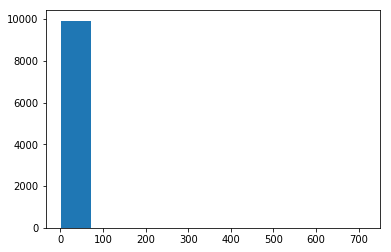

In [162]:
plt.hist(trips['speed_avg_mph'])

In [190]:
speed_winzd = mstats.winsorize(trips['speed_avg_mph'], limits=[0, 0.0081])
trips_dft['speed_avg_mph'] = np.log(speed_winzd)

In [188]:
#trips['speed_avg_mph'].sort_values(ascending=False).head()

In [192]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
additional_charges            10000 non-null float64
dropoff_census_tract          7187 non-null object
dropoff_centroid_latitude     9334 non-null object
dropoff_centroid_location     9334 non-null object
dropoff_centroid_longitude    9334 non-null object
dropoff_community_area        9322 non-null object
fare                          10000 non-null float64
pickup_census_tract           7207 non-null object
pickup_centroid_latitude      9392 non-null object
pickup_centroid_location      9392 non-null object
pickup_centroid_longitude     9392 non-null object
pickup_community_area         9383 non-null object
shared_trip_authorized        10000 non-null bool
tip                           10000 non-null float64
trip_end_timestamp            10000 non-null object
trip_id                       10000 non-null object
trip_miles                    10000 non-null float64
trip_seconds    

## Data Exploration and Visualization

Questions Worth Answering:
- Where do ride hailing pickups concentrate in?
- How does ride volume vary over time? Different time scales?
- How often and to what extent to patrons tip?
- How does average speed change with drop off location? Time of day?
- How likely is a rider to ride alone while still authorizing a pooled ride?
- What's the average cost of a rides being picked up and/or dropped off in Chicago?

In [194]:
# What's the average cost of a rides being picked up and/or dropped off
# in Chicago?
trips['trip_total'].describe()

count    10000.000000
mean        16.112567
std         12.385609
min          0.720000
25%          7.550000
50%         12.550000
75%         18.050000
max        184.000000
Name: trip_total, dtype: float64

In [199]:
# What is the time frame for all rides in the dataset?
trips['trip_start_timestamp'].sort_values(ascending=True).head()

582     2019-03-30T00:00:00.000
8796    2019-03-30T00:00:00.000
3954    2019-03-30T00:15:00.000
7728    2019-03-30T00:15:00.000
9935    2019-03-30T00:15:00.000
Name: trip_start_timestamp, dtype: object

In [201]:
trips['trip_start_timestamp'].sort_values(ascending=True).tail()

9072    2019-06-30T21:15:00.000
2923    2019-06-30T22:00:00.000
1720    2019-06-30T22:00:00.000
3636    2019-06-30T23:15:00.000
4748    2019-06-30T23:15:00.000
Name: trip_start_timestamp, dtype: object

In [204]:
# How many trips in each month?
trips_dft.groupby('tsstart_month').count()['trip_id']

tsstart_month
3     245
4    3165
5    3348
6    3242
Name: trip_id, dtype: int64

In [208]:
#How often do patrons tip their drivers?
trips[trips['tip'] > 0].count()['tip']/len(trips)

0.1897

In [210]:
#When patrons tip, how much do they often tip?
trips[trips['tip'] > 0]['tip'].describe()

count    1897.000000
mean        3.337902
std         2.477579
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        23.000000
Name: tip, dtype: float64

In [213]:
# Where do ride hailing pickups concentrate in?
trips_dft.groupby('pickup_community_area').count()['trip_id'].sort_values(ascending=False).head(10)

pickup_community_area
8     1609
32     915
28     816
6      673
24     612
7      518
22     384
76     364
33     236
3      200
Name: trip_id, dtype: int64

In [214]:
# How often to riders authorize pooled rides?
trips[trips['shared_trip_authorized'] == 1]['trip_id'].count()/len(trips)

0.2232

In [228]:
# Of all authorized_shared trips, how often does the ride end up unshared?
unshared_pooled = trips[(trips['shared_trip_authorized'] == 1) & (trips['trips_pooled'] == 1)]['trip_id'].count()
all_pooled = trips[trips['shared_trip_authorized'] == 1]['trip_id'].count()
unshared_pooled/all_pooled

0.30913978494623656

About 1/3 of shared authorized rides don't end up driving more than one person or collective set of people.

In [226]:
#What's the average speed of riders drivers each day in Chicago?
= trips_dft.groupby(['tsstart_month', 'tsstart_day']).mean()['speed_avg_mph'].head()

tsstart_month  tsstart_day
3              30             2.726053
               31             2.903835
4              1              2.850070
               2              2.832851
               3              2.665326
Name: speed_avg_mph, dtype: float64

In [227]:
trips_dft.groupby(['tsstart_month', 'tsstart_day']).mean()['speed_avg_mph'].tail()

tsstart_month  tsstart_day
6              26             2.700631
               27             2.757248
               28             2.685105
               29             2.725105
               30             2.805733
Name: speed_avg_mph, dtype: float64

These are logged speed so these aren't the actual speeds.

In [230]:
day_avg_speeds = trips_dft.groupby(['tsstart_month', 'tsstart_day']).mean()['speed_avg_mph']
np.exp(day_avg_speeds).head()

tsstart_month  tsstart_day
3              30             15.272487
               31             18.243979
4              1              17.288997
               2              16.993841
               3              14.372635
Name: speed_avg_mph, dtype: float64

In [231]:
np.exp(day_avg_speeds).tail()

tsstart_month  tsstart_day
6              26             14.889126
               27             15.756428
               28             14.659744
               29             15.258019
               30             16.539197
Name: speed_avg_mph, dtype: float64

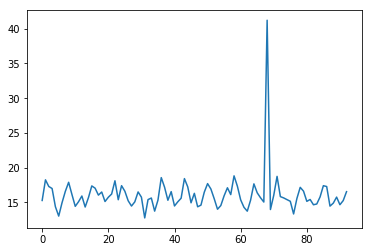

In [237]:
plt.plot(np.exp(day_avg_speeds).as_matrix())

There seems to be a weekly avg speed cycle.

In [239]:
#np.exp(day_avg_speeds).as_matrix()